# Caderno 9 - Calcula métricas para pesquisa em banco vetorial

In [1]:
###############################################################################
# Modelos
#MODELO = 'rufimelo/Legal-BERTimbau-sts-large-ma-v3'
#MAX_SEQ_LENGTH = 512

MODELO = 'sentence-transformers/paraphrase-multilingual-mpnet-base-v2'
MAX_SEQ_LENGTH = 128
###############################################################################

CAMINHO_MODELO = MODELO.split("/")[-1]

# Seleciona o tipo de camada oculta
TIPO_CAMADA_OCULTA = 'mean_hidden_state'
#TIPO_CAMADA_OCULTA = 'cls_hidden_state'

PASTA_DADOS = './dados/'
PASTA_RESULTADO_CADERNO = f'{PASTA_DADOS}outputs/9_calcula_metricas/{CAMINHO_MODELO}/'
PASTA_RESULTADO_BUSCA = f'{PASTA_DADOS}outputs/8_armazena_dados_em_banco_vetorial/{CAMINHO_MODELO}/'
ARQUIVO_RESULTADO_BUSCA = f'{PASTA_RESULTADO_BUSCA}{CAMINHO_MODELO}_{TIPO_CAMADA_OCULTA}_resultado_query.pickle'

## 1. Carrega dados de jurisprudência

In [2]:
import pandas as pd

# A pasta dos JURIS aqui não é a pasta original, e sim o resultado do caderno 1 (os documentos já estão filtrados)
PASTA_JURIS_TCU = f'{PASTA_DADOS}outputs/1_tratamento_juris_tcu/'

# Carrega os arquivos 
def carrega_juris_tcu():
    doc1 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_1.csv', sep='|')
    doc2 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_2.csv', sep='|')
    doc3 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_3.csv', sep='|')
    doc4 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_4.csv', sep='|')
    doc = pd.concat([doc1, doc2, doc3, doc4], ignore_index=True)
    query = pd.read_csv(f'{PASTA_JURIS_TCU}query_tratado.csv', sep='|')
    qrel = pd.read_csv(f'{PASTA_JURIS_TCU}qrel_tratado.csv', sep='|')

    return doc, query, qrel

docs, queries, qrels = carrega_juris_tcu()

## 2. Carrega resultados da busca em banco vetorial

Carrega a lista dos resultados das queries realizadas no banco vetorial.

In [3]:
import pickle

with open(ARQUIVO_RESULTADO_BUSCA, 'rb') as arquivo:
    I = pickle.load(arquivo)
I.shape

(150, 50)

## 3. Constroi dataframe de resultados no formato esperado pela função de métricas


In [4]:
import pandas as pd

# Função para encontrar a correspondência entre keys
def find_key(doc_key, docs):
    matches = docs[docs['KEY'].str.contains(doc_key, na=False)]
    if not matches.empty:
        return matches.iloc[0]['KEY']
    return doc_key

# Criando listas para as colunas do DataFrame
col_resultado_query_key = []
col_resultado_doc_key = []
col_resultado_rank = []

# Preenchendo as listas
for query_idx in range(len(I)):
    for rank_idx in range(len(I[0])):
        col_resultado_query_key.append(query_idx+1)
        col_resultado_doc_key.append(I[query_idx, rank_idx])
        col_resultado_rank.append(rank_idx+1)

df_resultados = pd.DataFrame({
    "QUERY_KEY": col_resultado_query_key,
    "DOC_KEY": col_resultado_doc_key,
    "RANK": col_resultado_rank,
})

df_resultados['DOC_KEY'] = df_resultados['DOC_KEY'].astype(str)
df_resultados['DOC_KEY'] = df_resultados['DOC_KEY'].apply(lambda x: find_key(x, docs))

In [5]:
df_resultados

,QUERY_KEY,DOC_KEY,RANK
0,1,JURISPRUDENCIA-SELECIONADA-20870,1
1,1,JURISPRUDENCIA-SELECIONADA-31523,2
2,1,JURISPRUDENCIA-SELECIONADA-20956,3
3,1,JURISPRUDENCIA-SELECIONADA-20969,4
4,1,JURISPRUDENCIA-SELECIONADA-48258,5
...,...,...,...
7495,150,JURISPRUDENCIA-SELECIONADA-15764,46
7496,150,JURISPRUDENCIA-SELECIONADA-67096,47
7497,150,JURISPRUDENCIA-SELECIONADA-18195,48
7498,150,JURISPRUDENCIA-SELECIONADA-32938,49


In [6]:
queries

,KEY,TEXT,SOURCE
0,1,técnica e preço,search log
1,2,restos a pagar,search log
2,3,aditivo a contrato,search log
3,4,adesão a ata de registro de preços,search log
4,5,sobrepreço e superfaturamento,search log
...,...,...,...
145,146,É possível a inclusão de serviços já previstos...,LLM
146,147,O princípio da legalidade estrita pode ser afa...,LLM
147,148,Quais fontes devem ser prioritárias na pesquis...,LLM
148,149,Devem ser aceitas nas contratações de software...,LLM


## 3. Calcula métricas

In [7]:
from metricas import metricas

df_metricas = metricas(df_resultados, qrels, aproximacao_trec_eval=True)

,QUERY_KEY,P@5,P@10,P@20,P@50,R@5,R@10,R@20,R@50,MRR@5,MRR@10,MRR@20,MRR@50,nDCG@5,nDCG@10,nDCG@20,nDCG@50
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,25.50000,0.188000,0.146000,0.113000,0.062000,0.075289,0.116379,0.177127,0.241623,0.333667,0.351246,0.354603,0.355507,0.181712,0.160811,0.189319,0.220679
std,14.57738,0.243813,0.165628,0.113753,0.057179,0.105161,0.139119,0.187595,0.229042,0.399241,0.387034,0.384275,0.383448,0.254874,0.200307,0.208984,0.225942
min,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.25000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,25.50000,0.200000,0.100000,0.100000,0.060000,0.066667,0.076923,0.153846,0.207143,0.200000,0.200000,0.200000,0.200000,0.083853,0.086574,0.141570,0.187769
75%,37.75000,0.200000,0.200000,0.150000,0.100000,0.089015,0.142857,0.241071,0.390909,0.500000,0.500000,0.500000,0.500000,0.275796,0.232250,0.258135,0.327056
max,50.00000,1.000000,0.600000,0.450000,0.200000,0.500000,0.500000,0.750000,0.909091,1.000000,1.000000,1.000000,1.000000,1.000000,0.728913,0.821152,0.867099


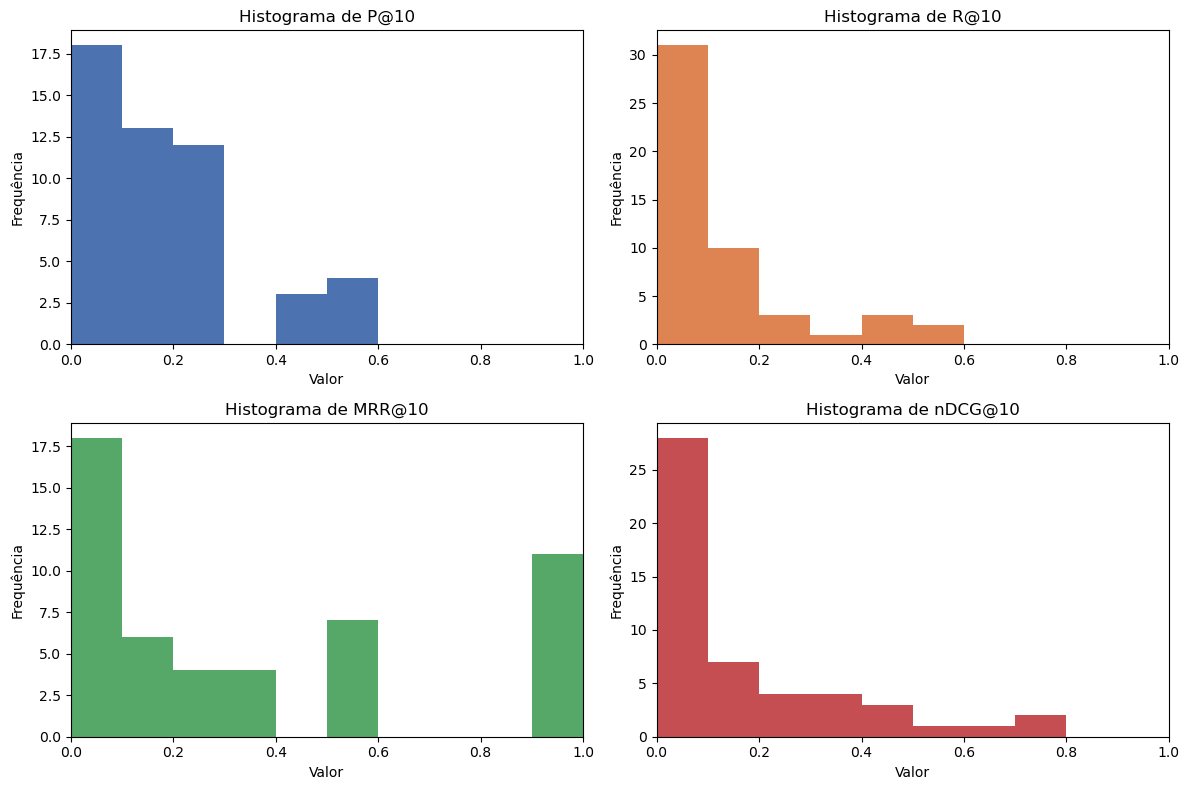

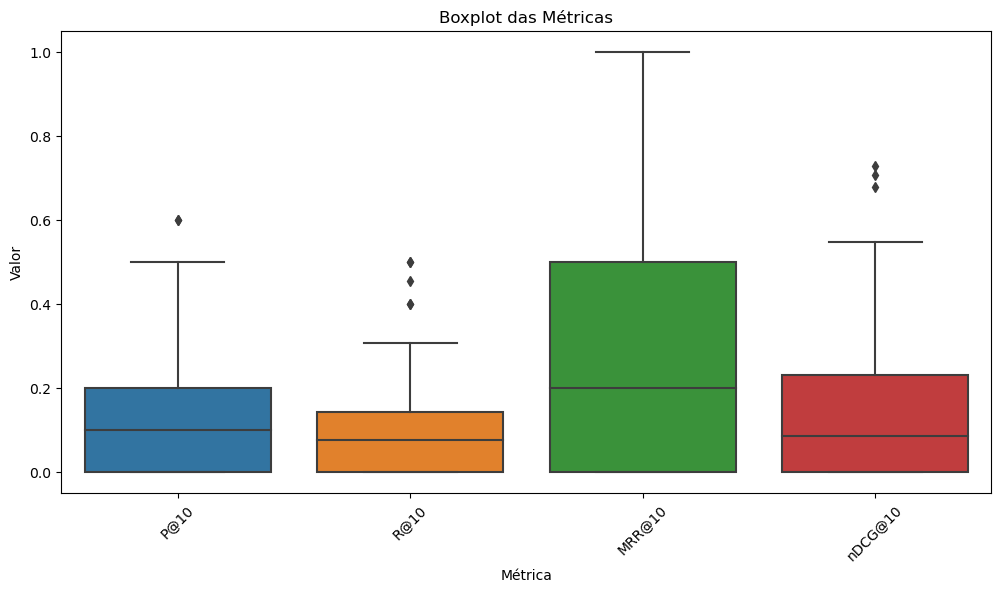

In [8]:
from metricas import histograma_metricas, boxplot_metricas

# Resultados para o primeiro grupo de queries:
display(df_metricas[0:50].describe())
histograma_metricas(df_metricas[0:50])
boxplot_metricas(df_metricas[0:50])

,QUERY_KEY,P@5,P@10,P@20,P@50,R@5,R@10,R@20,R@50,MRR@5,MRR@10,MRR@20,MRR@50,nDCG@5,nDCG@10,nDCG@20,nDCG@50
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,75.50000,0.332000,0.246000,0.167000,0.087600,0.134537,0.202812,0.274202,0.358834,0.595000,0.605079,0.605079,0.605685,0.345526,0.314590,0.340138,0.376502
std,14.57738,0.263756,0.179807,0.127219,0.058539,0.110375,0.153984,0.214277,0.247461,0.424254,0.411041,0.411041,0.410152,0.257531,0.211863,0.230582,0.236075
min,51.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,63.25000,0.200000,0.100000,0.100000,0.040000,0.072802,0.083333,0.145604,0.166667,0.250000,0.250000,0.250000,0.250000,0.084554,0.143383,0.179347,0.196159
50%,75.50000,0.300000,0.200000,0.150000,0.080000,0.112121,0.181818,0.250000,0.357143,0.500000,0.500000,0.500000,0.500000,0.365506,0.324268,0.345820,0.394469
75%,87.75000,0.600000,0.400000,0.250000,0.135000,0.230769,0.298951,0.377747,0.528846,1.000000,1.000000,1.000000,1.000000,0.549472,0.485567,0.479694,0.574410
max,100.00000,1.000000,0.800000,0.450000,0.200000,0.400000,0.727273,0.900000,0.909091,1.000000,1.000000,1.000000,1.000000,0.782603,0.825218,0.844672,0.885684


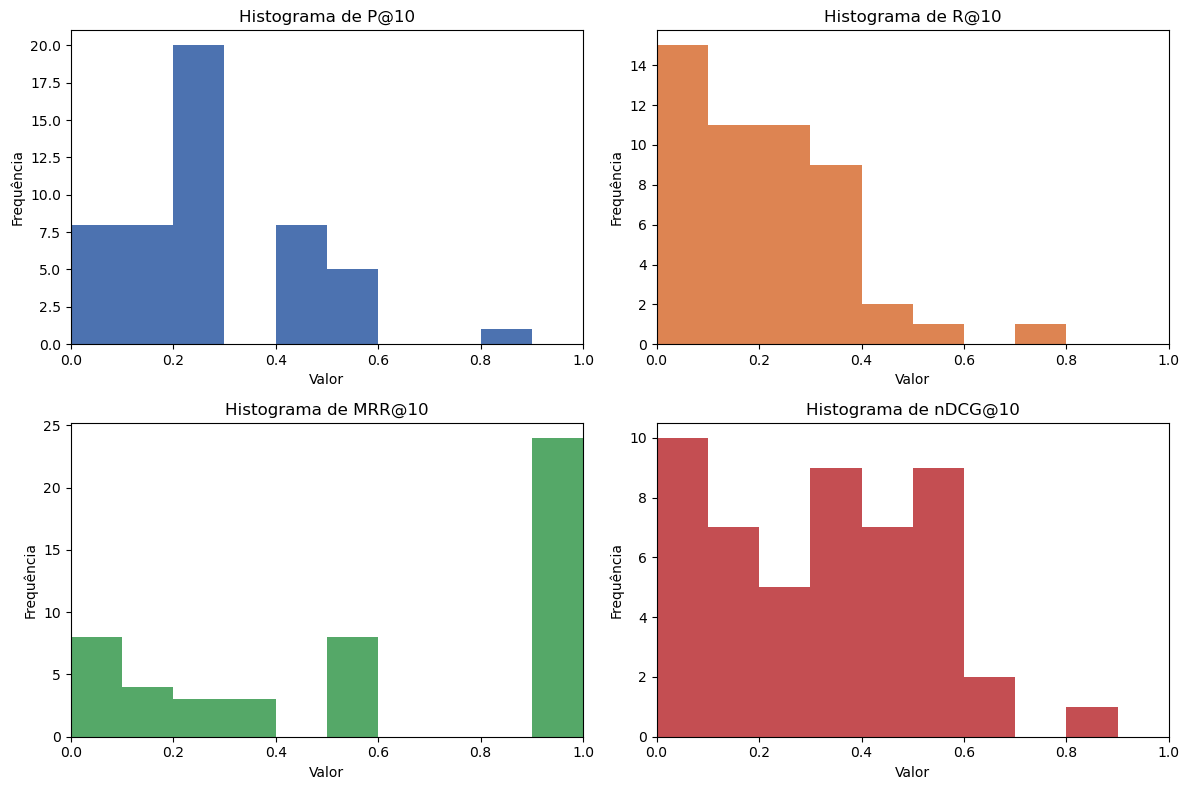

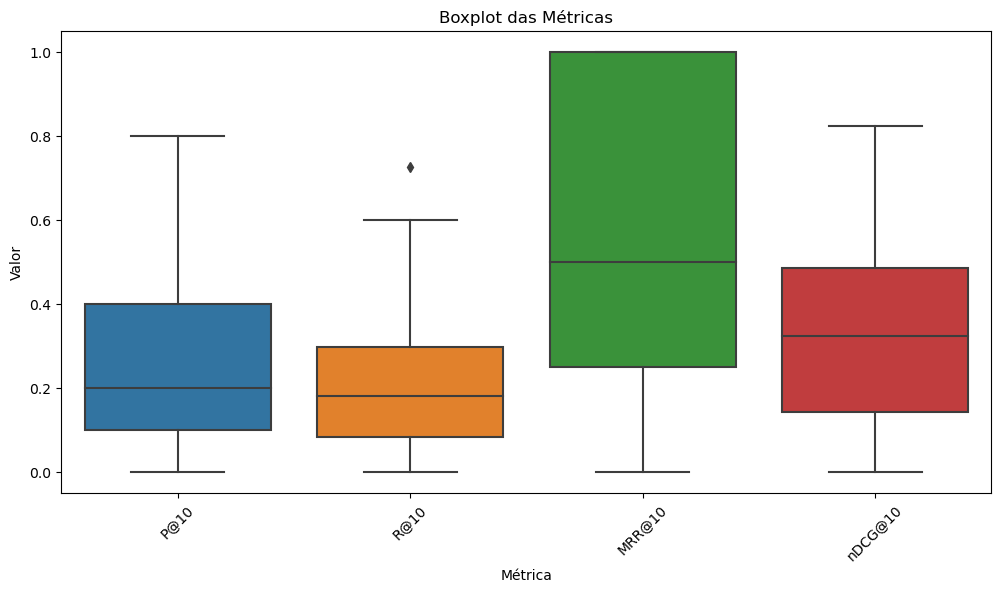

In [9]:
# Resultados para o segundo grupo de queries:
display(df_metricas[50:100].describe())
histograma_metricas(df_metricas[50:100])
boxplot_metricas(df_metricas[50:100])

,QUERY_KEY,P@5,P@10,P@20,P@50,R@5,R@10,R@20,R@50,MRR@5,MRR@10,MRR@20,MRR@50,nDCG@5,nDCG@10,nDCG@20,nDCG@50
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,125.50000,0.496000,0.344000,0.213000,0.111600,0.219196,0.304719,0.373362,0.485738,0.782333,0.791857,0.795494,0.796234,0.535055,0.451914,0.477475,0.524447
std,14.57738,0.289235,0.203199,0.111945,0.052386,0.127052,0.183106,0.195562,0.225485,0.370396,0.351347,0.343354,0.341639,0.284310,0.222219,0.219500,0.224375
min,101.00000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.037037,0.000000,0.000000,0.000000,0.095899
25%,113.25000,0.250000,0.200000,0.150000,0.080000,0.157051,0.166667,0.214286,0.301923,0.500000,0.500000,0.500000,0.500000,0.374748,0.316229,0.338936,0.386800
50%,125.50000,0.600000,0.300000,0.200000,0.110000,0.222527,0.279221,0.363636,0.460606,1.000000,1.000000,1.000000,1.000000,0.556508,0.470172,0.507761,0.562934
75%,137.75000,0.800000,0.500000,0.300000,0.160000,0.307692,0.396154,0.500000,0.659091,1.000000,1.000000,1.000000,1.000000,0.762221,0.603390,0.606650,0.678694
max,150.00000,1.000000,0.900000,0.500000,0.200000,0.454545,0.818182,0.909091,0.909091,1.000000,1.000000,1.000000,1.000000,1.000000,0.914170,0.951796,0.951796


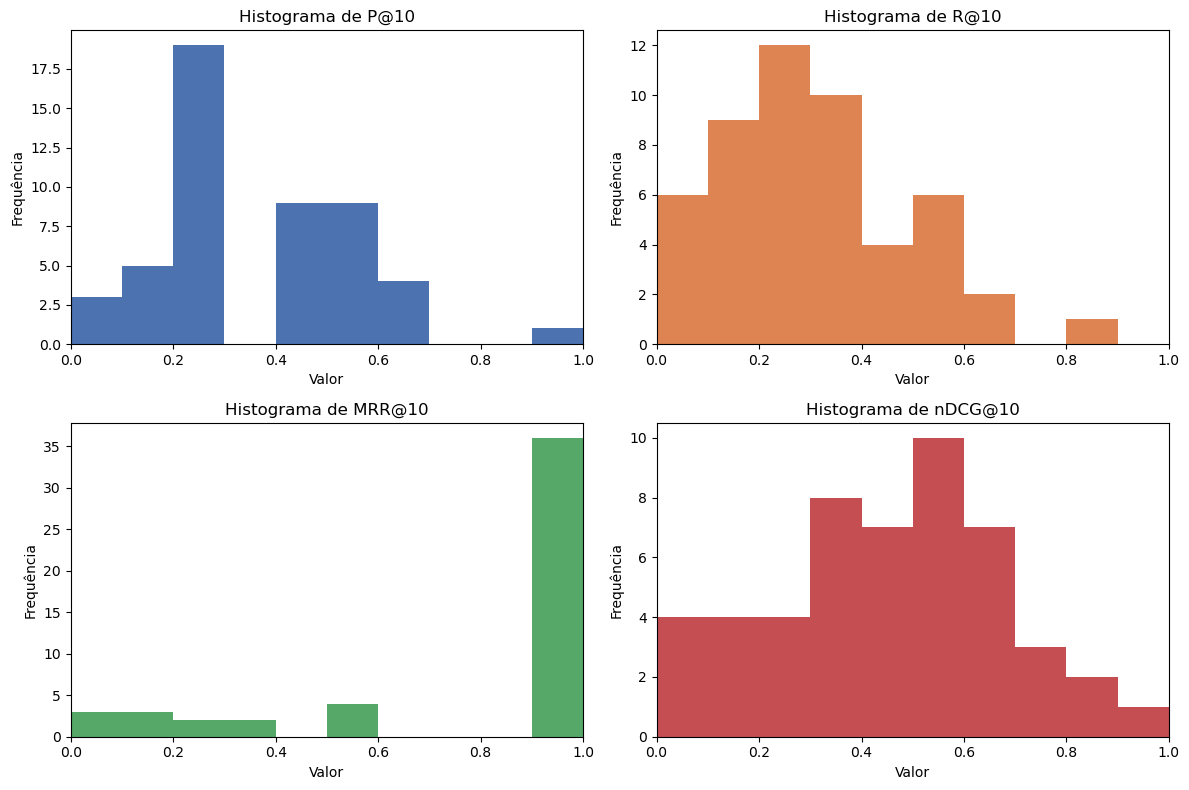

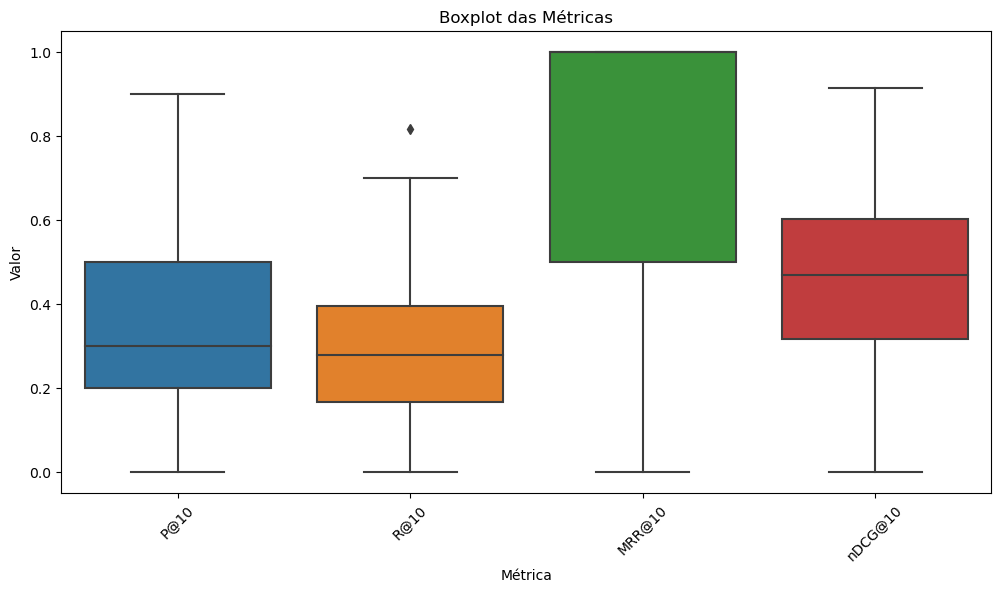

In [10]:
# Resultados para o terceiro grupo de queries:
display(df_metricas[100:150].describe())
histograma_metricas(df_metricas[100:150])
boxplot_metricas(df_metricas[100:150])